## Requirements e import

In [ ]:
# Imports
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import pickle
from time import time
import tensorflow as tf
from tensorflow import keras
from skimage import io 
from keras import Model
from keras import Input
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# KDTree creation and saving
from sklearn.neighbors import KDTree
import joblib

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Import train features and labels

In [ ]:
train_info = pd.read_csv('rain_info.csv', header=None)
lista_imtrain = train_info[1].tolist()
lista_imtrain = lista_imtrain[1:len(lista_imtrain)]
print(len(lista_imtrain))

118474


In [ ]:
train_mobilenet = np.load('train_mobilenet.npy')
train_mobilenet.shape

(118475, 1280)

In [ ]:
df_labels = pd.read_csv('train_info.csv',
                         names=['Class']) 
df_labels = df_labels.reset_index()
df_labels['Name'] = df_labels['level_1']
print(df_labels.shape)

train_labels = pd.DataFrame(lista_imtrain[0:len(lista_imtrain)])
train_labels.columns = ['Name']
print(train_labels.shape)

join_labels = train_labels.merge(df_labels, on='Name', how='left')
train_labels = join_labels['Class'].tolist()
train_labels = join_labels['Class']

one_hot_encoded_train_labels = tf.keras.utils.to_categorical(train_labels)
print(len(one_hot_encoded_train_labels))

(118475, 4)
(118474, 1)
118474


In [ ]:
similarity_df = pd.DataFrame(lista_imtrain, columns=['Name'])
similarity_df['Label'] = train_labels
similarity_df['Similarity'] = np.nan
similarity_df.head()

,Name,Label,Similarity
0,train_101734.jpg,211,NaN
1,train_101735.jpg,211,NaN
2,train_101736.jpg,211,NaN
3,train_101737.jpg,211,NaN
4,train_101738.jpg,211,NaN


## Import valid dataset and labels

In [ ]:
val_info = pd.read_csv('val_info.csv', header=None)
lista_imvalid = val_info[1].tolist()
lista_imvalid = lista_imvalid[1:len(lista_imvalid)]
print(len(lista_imvalid))

11993


## Definizione similarity

In [ ]:
input_t = Input(shape=(224, 224, 3))
temp = MobileNetV2(weights='imagenet', input_tensor=input_t)
temp.summary()

14536120/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [ ]:
desired_layer = temp.get_layer('global_average_pooling2d')
newmodel = Model(inputs=input_t, outputs=desired_layer.output)
newmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
def mobilenet_features(img):
    x = kimage.img_to_array(img)
    x = keras.applications.mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    f = newmodel.predict(x, verbose=False)
    return f

In [ ]:
# Get feature vector of an image by given model and img_path
def getFeatureVector(img_name):

  # Load file and extract features
  img_path = '/content/val_set/'+img_name
  image = kimage.load_img(img_path, target_size=(224, 224))
  features = mobilenet_features(image)

  features = np.array(features)
  return features

In [ ]:
# Get cosine similarity between feature vectors A and B using cosine similarity
def getCosineSimilarity(A, B):
  cos_similarity = np.dot(A,B.T) / (np.linalg.norm(A)*np.linalg.norm(B)) 
  return cos_similarity

In [ ]:
def getQueryLabel(img_name, train=False):
  if not train:
    df_labels = pd.read_csv('val_info.csv',
                          names=['Class'])
  else:
    df_labels = pd.read_csv('train_info.csv',
                          names=['Class'])
  df_labels = df_labels.reset_index()
  df_labels['Name'] = df_labels['level_1']
  return df_labels[df_labels['level_1']==img_name]['Class'].values[0]

In [ ]:
annot_data = pd.read_csv("class_list.txt", sep=" ", header=None)
annot_data.columns = ["Number", "Name"]

In [ ]:
# Plot similar 5 images with given image and similar images dataframe
def plotSimilarImages(img_file, similar_df):
  img = kimage.load_img('/content/val_set/' + img_file, target_size=(224, 224))

  img_class = getQueryLabel(img_file)
  fig, axarr = plt.subplots(2,3,figsize=(15, 8))
  axarr[0,0].imshow(img)
  axarr[0,0].set_title("TEST IMAGE - " + "\nClass: " + annot_data[annot_data['Number']==img_class]['Name'].values[0])
  axarr[0,0].axis('off')

  j, k, m = 0, 0, 1
  for index, sim in similar_df.iterrows():
    sim_class = getQueryLabel(sim['Name'], train=True)
    similarity = sim['Similarity']

    similar = kimage.load_img('Data/Train/' + sim['Name'], target_size=(224, 224))
    axarr[k,m].imshow(similar)
    axarr[k,m].set_title("Similarity: %.3f" % similarity + "\nClass: " + annot_data[annot_data['Number']==sim_class]['Name'].values[0])
    axarr[k,m].axis('off')

    m += 1
    if m == 3 and k != 1:
      k += 1
      m = 0

    j += 1
    if j == 5:
      break

  plt.tight_layout()
  plt.show()

In [ ]:
def evaluate(sim_df, query_class):
  accuracy = 0
  for i in sim_df['Label'][0:5].values:
    if i == query_class:
      accuracy += 1
  return accuracy/5

In [ ]:
# Get and plot 5 similar images for given image path and features dataframe
def getSimilarImages(img_file, evaluation=False):
  img_features = getFeatureVector(img_file)
  img_features = img_features[0, :]

  for i in range(0,similarity_df.shape[0]):
    similarity_df.loc[i,'Similarity'] = getCosineSimilarity(img_features, train_mobilenet[i,:])

  sorted_df = similarity_df.sort_values(by='Similarity', ascending=False)

  if evaluation:
    # return sorted_df, getQueryLabel(img_file)
    return evaluate(sorted_df, getQueryLabel(img_file))

  plotSimilarImages(img_file, sorted_df.head(5))

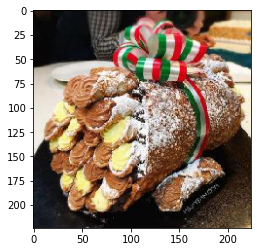

In [ ]:
img_path = 'Data/Validation/' + 'val_000008.jpg'

# Load file and extract features
image = kimage.load_img(img_path, target_size=(224, 224))
plt.imshow(image)

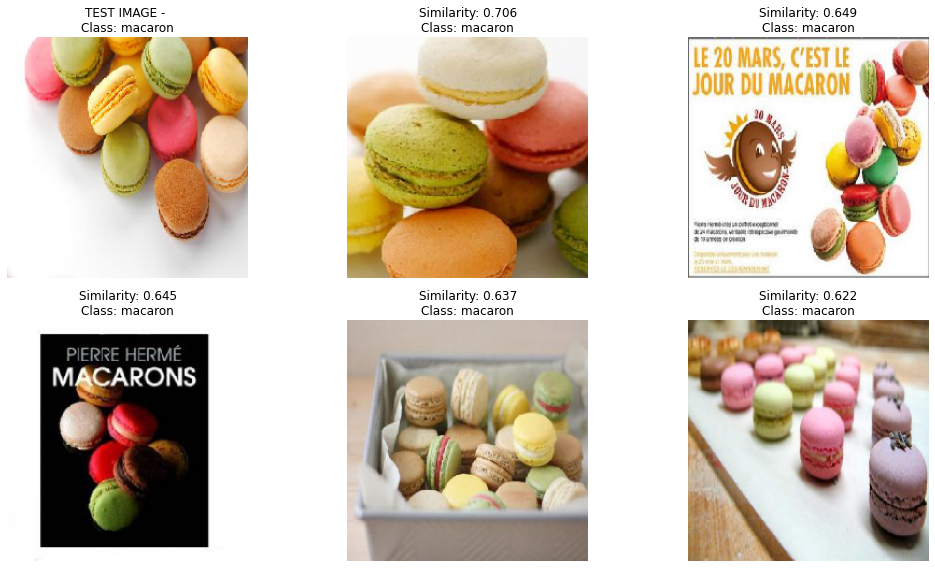

Time required: 11.315 seconds.


In [ ]:
# Get similar images of test image
t0 = time.time()
getSimilarImages(lista_imvalid[5])
print("Time required: %0.3f seconds." % (time.time() - t0))

In [ ]:
# Get similar images of test image
t0 = time.time()
out = getSimilarImages('val_000008.jpg', evaluation=True)
print("Time required: %0.3f seconds." % (time.time() - t0))

Time required: 8.258 seconds.


In [ ]:
t0 = time.time()
li_acc = []

for name in lista_imvalid:
  li_acc.append(getSimilarImages(name, evaluation=True))
print("Time required: %0.3f seconds." % (time.time() - t0))

print(sum(li_acc) / len(li_acc))

Time required: 719.884 seconds.
0.30999999999999994


The top-5 accuracy is above 30%, i.e. on average 1-2 images among the top 5 belong to the same class as the query image.

## Test con KDTree

In [ ]:
# tree = KDTree(train_mobilenet)

# # Saving the search tree
# joblib.dump(tree, 'cbri_kdtree.joblib')

# name = 'val_000003.jpg'

# # Loading a query image
# query_image = kimage.load_img('Data/Validation/'+name, target_size=(224, 224))
# plt.imshow(query_image)

# # Computing query features
# query_features = mobilenet_features(query_image)
# query_features = np.array(query_features)
# query_features.shape

# # Search
# dist, ind = tree.query(query_features, k=10)

# def getQueryLabel_train(img_name):
  
#   df_labels = pd.read_csv('train_info.csv',
#                           names=['Class'])
#   df_labels = df_labels.reset_index()
#   df_labels['Name'] = df_labels['level_1']
#   return df_labels[df_labels['level_1']==img_name]['Class'].values[0]

# target_class = getQueryLabel(name)
# accuracy = 0

# for i in range(0,ind.shape[1]):
#   if getQueryLabel_train(lista_imtrain[ind[0][i]]) == target_class:
#     accuracy += 1

# print(accuracy/ind.shape[1])


# img = query_image
# img_class = getQueryLabel('val_000003.jpg')
# fig, axarr = plt.subplots(2,3,figsize=(15, 8))
# axarr[0,0].imshow(img)
# axarr[0,0].set_title("TEST IMAGE - " + "\nClass: " + annot_data[annot_data['Number']==img_class]['Name'].values[0])
# axarr[0,0].axis('off')

# j, k, m = 0, 0, 1
# for i in range(0,5):

#   name_similar = lista_imtrain[ind[0][i]]
#   img = kimage.load_img('/content/train_set/' + name_similar, target_size=(224, 224))
#   img_class = getQueryLabel(name_similar, train=True)
#   axarr[k,m].imshow(img)
#   axarr[k,m].set_title("Similarity: %.3f" % dist[0][i] + "\nClass: " + annot_data[annot_data['Number']==img_class]['Name'].values[0])
#   axarr[k,m].axis('off')

#   m += 1
#   if m == 3 and k != 1:
#     k += 1
#     m = 0

#   j += 1
#   if j == 5:
#     break

# plt.tight_layout()
# plt.show()

Using the KDTree search method improves query times by about 50 per cent but leads to a worsening of the top-5 accuracy by up to 25 per cent. Since the query times are still moderate (about 10s), we decide to keep the first method.